<a href="https://colab.research.google.com/github/NAVEED261/MY-AI-ASSISTANT/blob/main/2_MY_AGENT_IS_MY_DOCTOR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_google_genai langchain_core langgraph requests

In [ ]:
from google.colab import userdata
GEMINI_API_KEY = userdata.get('GOOGLE_API_KEY')

In [ ]:
from google.colab import userdata
LANGCHAIN_API_KEY = userdata.get('langchain')

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key = GEMINI_API_KEY)
llm.invoke("assalamualyum , i m hafiz naveed uddin , how r u?")

AIMessage(content='Assalamu alaykum Hafiz Naveed Uddin! I hope you are doing well.  How can I help you today?\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-613e575b-28c8-4535-b08f-645b349c4e21-0', usage_metadata={'input_tokens': 19, 'output_tokens': 28, 'total_tokens': 47, 'input_token_details': {'cache_read': 0}})

In [ ]:
BASE_URL = "https://api.endlessmedical.com/v1"

In [ ]:
def get_medical_features() -> str:
    """Retrieves medical features from Endless Medical API."""
    response = requests.get(f"{BASE_URL}/dx/GetFeatures")
    if response.status_code == 200:
        return str(response.json())
    else:
        return "Failed to retrieve medical features."

def provide_health_tips(symptom: str) -> str:
    """Provides health tips for specific symptoms."""
    health_tips = {
        "fever": "Stay hydrated, rest, and take paracetamol.",
        "cough": "Drink warm fluids, avoid cold drinks, and use cough syrup.",
        "headache": "Rest in a quiet room, hydrate, and take painkillers.",
        "stomach pain": "Avoid spicy food, drink water, and take antacids."
    }
    return health_tips.get(symptom.lower(), "Consult a doctor for accurate advice.")

def get_medicine_recommendation(symptom: str) -> str:
    """Fetches a medicine recommendation from EndlessMedical API for a given symptom."""
    params = {"symptom": symptom}
    response = requests.get(f"{BASE_URL}/dx/GetOutcomes", params=params)

    # Debugging API Response
    print("API Response Status Code:", response.status_code)
    print("API Response JSON:", response.json())

    if response.status_code == 200:
        data = response.json()
        # Debugging JSON Key
        try:
            outcomes = data.get("Outcomes", [])
            if outcomes:
                medicine = outcomes[0].get("Name", "No specific medicine found")
                return f"Recommended medicine: {medicine}"
            else:
                return "No specific medicine available in the API response."
        except Exception as e:
            return f"Error parsing API response: {str(e)}"
    else:
        return f"Failed to fetch data. Status Code: {response.status_code}"
# Combine Tools
tools = [provide_health_tips, get_medicine_recommendation, get_medical_features]

# Bind tools to LLM
llm_with_tools = llm.bind_tools(tools)

In [ ]:
llm_with_tools

RunnableBinding(bound=ChatGoogleGenerativeAI(model='models/gemini-1.5-flash', google_api_key=SecretStr('**********'), client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x7fe0600f5090>, default_metadata=()), kwargs={'tools': [{'type': 'function', 'function': {'name': 'provide_health_tips', 'description': 'Provides health tips for specific symptoms.', 'parameters': {'properties': {'symptom': {'type': 'string'}}, 'required': ['symptom'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'get_medicine_recommendation', 'description': 'Fetches a medicine recommendation from EndlessMedical API for a given symptom.', 'parameters': {'properties': {'symptom': {'type': 'string'}}, 'required': ['symptom'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'get_medical_features', 'description': 'Retrieves medical features from Endless Medical API.', 'parameters': {'properties': {}, 'type': 'object'}}}]}, config

In [ ]:
print(get_medicine_recommendation("headache"))


API Response Status Code: 200
API Response JSON: {'status': 'ok', 'data': ['DM2', 'ANEMIAA', 'Thrombocytopenia', 'GcCervicitis', 'ProstatisA', 'GcUA', 'Covid19Test', 'CUA', 'Covid19Contact', 'CAPPNA', 'Covid19URTI', 'Covid19PNA', 'CommonCold', 'PancreatitisETOH', 'PancreatitisA', 'ClusterHeadache', 'UncontrolledHTN', 'DiabetesKACA', 'FusobacteriumNecrophorumPharyngitisComplicatedWithLemierreSyndrome', 'PrimaryArterialHypertension', 'PrimaryArterialHypertensionByHx', 'PancreatitisHyperTGL', 'PancreatitisGAP', 'PancreatitisHIV', 'HypertensiveEmergencyA', 'PancreatitisPancreaticCa', 'HeadacheAfterNitrates', 'HeadacheDueToHTN', 'HypertensiveUrgencyA', 'HeadacheDueToCaffeineWithdrawal', 'PancreatitisDueToMeds', 'PancreatitisHyperCalcemia', 'TensionHeadache', 'PancreatitisOddis', 'PancreatitisERCP', 'GastrittisBleedingA', 'MigraineHeadache', 'FusobacteriumNecrophorumPharyngitis', 'Leukopenia', 'BRONCHITISA', 'FluA', 'AorticDissectionThoracic', 'PeritionitisA', 'VaricealBleedingA', 'PTXA', 'C

In [ ]:
import requests
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display
from langgraph.graph.state import CompiledStateGraph
from langgraph.graph import MessagesState
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver
memory: MemorySaver = MemorySaver()

In [ ]:
sys_msg = SystemMessage(content="You are a knowledgeable healthcare assistant. Your goal is to provide helpful health advice, "
        "calculate BMI based on user inputs, and answer healthcare-related questions accurately. Always "
        "respond in a polite and empathetic tone, ensuring that the user feels heard and supported. "
        "For medical emergencies, recommend consulting a doctor.")

# Node
def assistant(state: MessagesState) -> MessagesState:
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

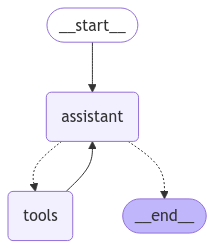

In [ ]:
# Graph
builder: StateGraph = StateGraph(MessagesState)


builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))  # Now tools is a list of BaseTool objects

builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",

    tools_condition,
)
builder.add_edge("tools", "assistant")
graph = builder.compile(checkpointer=memory)

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
config1 = {"configurable": {"thread_id": "1"}}


In [ ]:
messages = graph.invoke({"messages": [HumanMessage(content="I have a headache. Can you give me health tips?")]},config1)
for m in messages['messages']:
    m.pretty_print()


================================ Human Message =================================

I have a headache. Can you give me health tips?
================================== Ai Message ==================================

I'm sorry to hear that you have a headache.  I can certainly provide some health tips.
Tool Calls:
  provide_health_tips (1c77a2a2-9bb1-4d61-b343-29499a9b9d7c)
 Call ID: 1c77a2a2-9bb1-4d61-b343-29499a9b9d7c
  Args:
    symptom: headache
================================= Tool Message =================================
Name: provide_health_tips

Rest in a quiet room, hydrate, and take painkillers.
================================== Ai Message ==================================

I'm sorry to hear that you have a headache.  Here's what I can suggest based on my knowledge base: Try resting in a quiet, dark room.  Make sure you're drinking plenty of fluids. Over-the-counter pain relievers like ibuprofen or acetaminophen might also help.  

If your headache is severe, persistent, or ac

In [ ]:
messages = graph.invoke({"messages": [HumanMessage(content="What should I take for fever?")]},config1)
for m in messages['messages']:
    m.pretty_print()


================================ Human Message =================================

I have a headache. Can you give me health tips?
================================== Ai Message ==================================

I'm sorry to hear that you have a headache.  I can certainly provide some health tips.
Tool Calls:
  provide_health_tips (1c77a2a2-9bb1-4d61-b343-29499a9b9d7c)
 Call ID: 1c77a2a2-9bb1-4d61-b343-29499a9b9d7c
  Args:
    symptom: headache
================================= Tool Message =================================
Name: provide_health_tips

Rest in a quiet room, hydrate, and take painkillers.
================================== Ai Message ==================================

I'm sorry to hear that you have a headache.  Here's what I can suggest based on my knowledge base: Try resting in a quiet, dark room.  Make sure you're drinking plenty of fluids. Over-the-counter pain relievers like ibuprofen or acetaminophen might also help.  

If your headache is severe, persistent, or ac